<a href="https://colab.research.google.com/github/afarley9/perovskites/blob/main/examples/clustering_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.transforms import blended_transform_factory
import seaborn as sns
import random
import os
import sys
import pickle
import shutil

import tensorflow as tf
from tensorflow.keras import layers, Sequential
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import load_model
from scipy.cluster.vq import kmeans2, whiten

# Mount the drive and clone the github repo
drive.mount('/content/drive/')
!git clone https://github.com/afarley9/perovskites.git

# Import modules from the github repo
sys.path.append("/content/perovskites/perovskites")
import utils.image_processing as impr
import utils.image_loader as loader
import utils.miscellaneous as misc
import utils.autoencoder_to_encoder as ae

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
fatal: destination path 'perovskites' already exists and is not an empty directory.


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

Tensorflow version 2.4.1
Running on TPU  ['10.70.81.186:8470']


INFO:tensorflow:Initializing the TPU system: grpc://10.70.81.186:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.70.81.186:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
autoencoder = ae.autoencoder()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 16, 16, 16)        4624      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 8, 8, 8)           1160      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 8)           0   

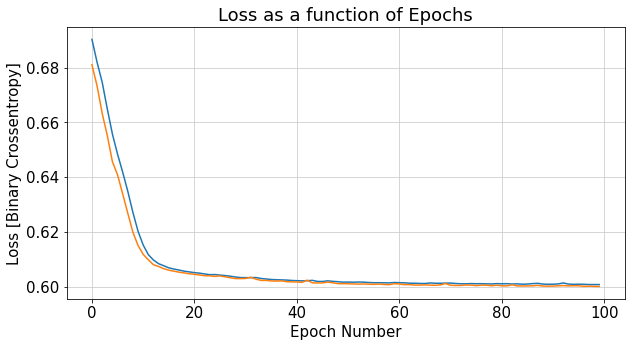

In [ ]:
ae_output = autoencoder.autoencoder_to_classification()

In [ ]:
input_data = ae_output[1]
ID_list = ae_output[2]
dataset = loader.PLDataLoader()

In [ ]:
def assign_IDs(dataset, ID_list):
    data = dataset.sample(frac=1.0)[0]
    ID_dict = {}
    for ii in range(len(ID_list)):
        if ID_list[ii][1] in ID_dict.keys():
            ID_dict[ID_list[ii][1]].append(data[ii])
        else:
            ID_dict[ID_list[ii][1]] = [data[ii]]
    return ID_dict

In [ ]:
def visualize_clusters(ID_dict, img_per_group = 10, color_map = 'gray'):
  """
  Takes a dictionary of (cluster group: images) as input and displays 
  random PL images from each cluster group
  
  Parameters
  -------------------
  ID_dict: dict
      Dictionary from assign_IDs function
  img_per_group: int
      How many images per group user wants to display 
  color_map: str
      User can decide cmap of displayed images
  
  Output:
  -------------------
  Random PL images from each cluster group

  """
  fig, axes  = plt.subplots(len(ID_dict), img_per_group, figsize = (20, 20))

  # Iterating over cluster groups
  for i in range(len(ID_dict)):
    size = len(ID_dict[i])

  # Need to deal with if the cluster group has less than img_per_group images
    if size < img_per_group: 
      r = np.arange(size) # Create indexed array
      z = size # Create so that when we plot the images, nested for loop does not go outside of range

    else:
      # Pick img_per_group random image numbers, then sort
      r = random.sample(range(size), img_per_group)
      r.sort()
      z = img_per_group


    for j in range(z):
      img = ID_dict[i][r[j]].reshape(32, 32) # Reshaping (32, 32, 1) into (32, 32) for easier plotting
      axes[i][j].imshow(img, cmap = color_map) # User can select preferred cmap when calling the function
      
    for k in range(z):
      axes[i][k].plot([1.07, 0.0], [1.05, 1.05], transform=axes[i][k].transAxes, clip_on=False, linewidth = 4, color = 'black')
      axes[i][k].get_xaxis().set_visible(False)
      axes[i][k].set_yticks([])

  rows = ['Group {}'.format(row) for row in range(len(ID_dict))]
  for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=90, size='large')
  fig.tight_layout()
  sns.despine(left=True, bottom=True, right=True)
      #ax[i][j].set_title("Cluster group = " + str(i) + " Group size = " + str(size) + " Image number  = " + str(r[j]))

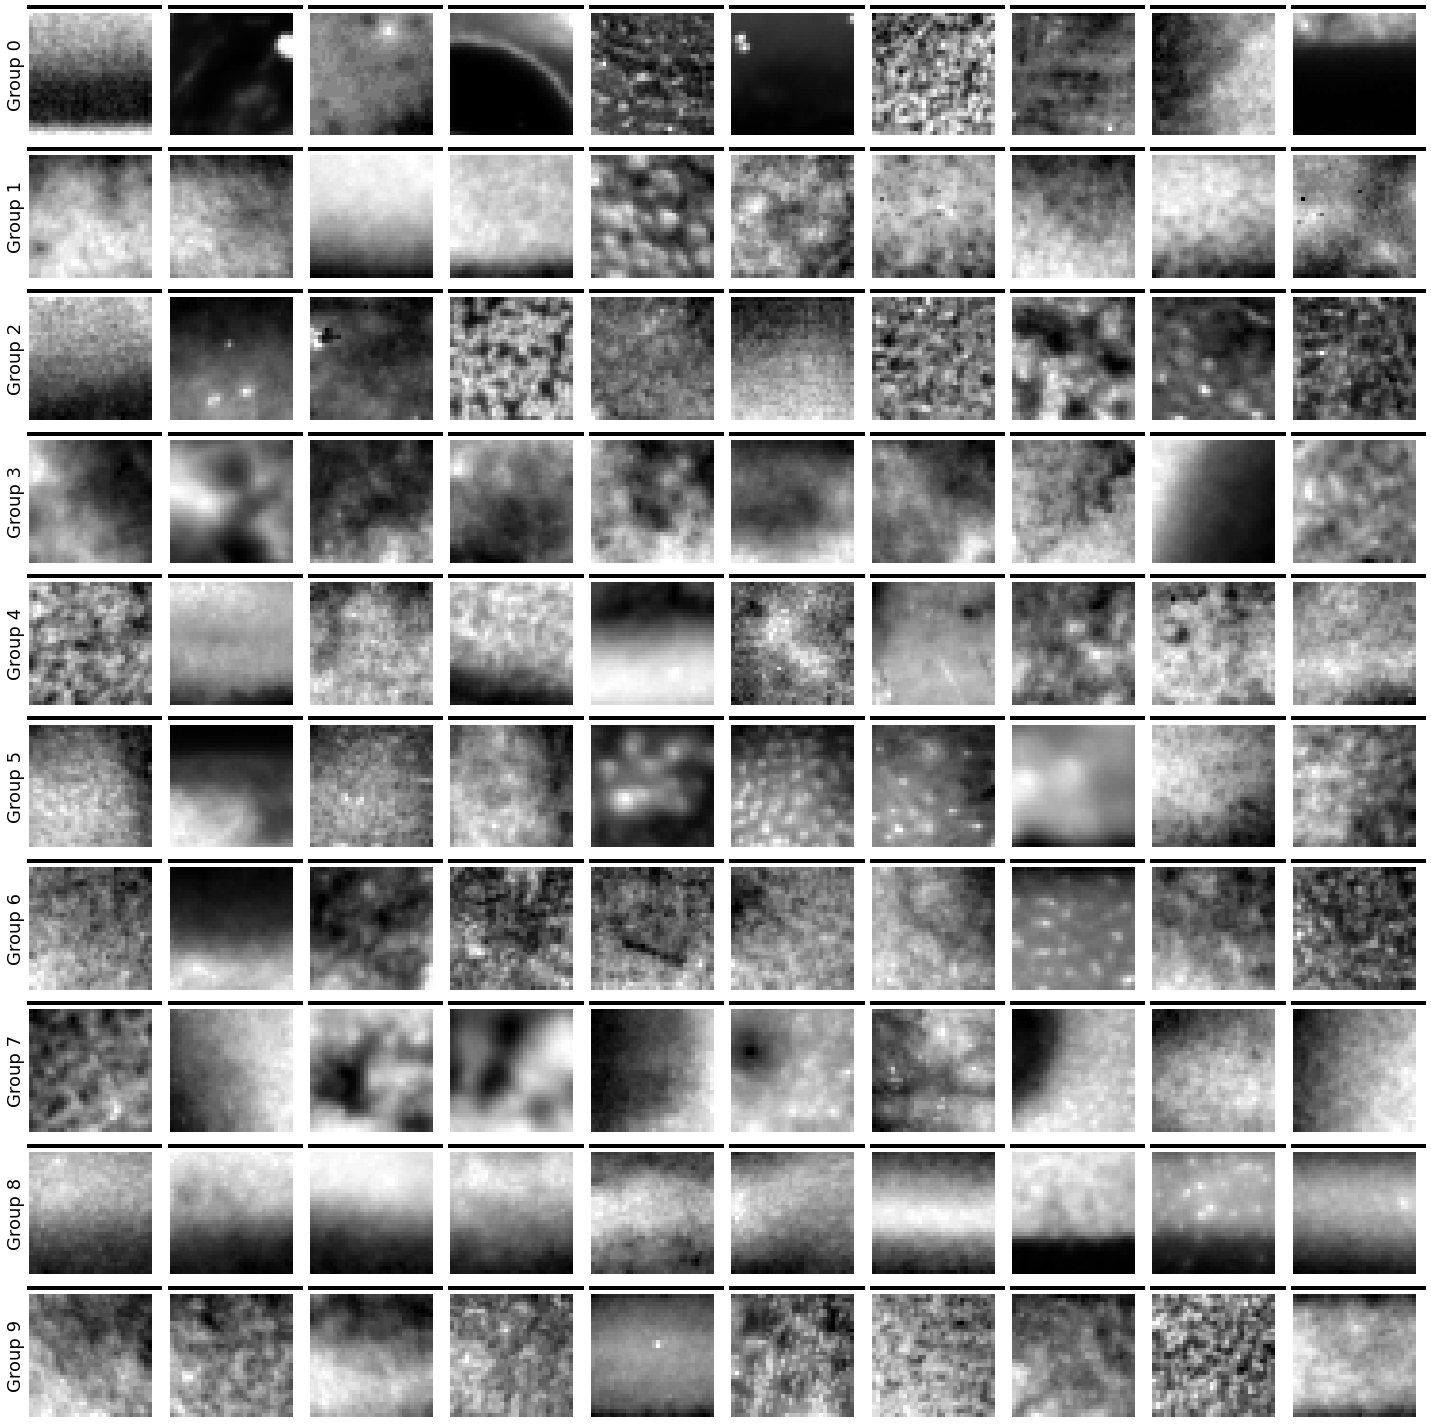

In [ ]:
visualize_clusters(assign_IDs(dataset, ID_list), img_per_group=10)